# COMP 534 - Applied Artificial Intelligence
## CA1 - Binary classification
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool. It comprises a performance analysis of three supervised machine learning methods for solving a binary classification problem.
### Preparation
#### Setup
Import required libraries, tools and classifiers.

In [1]:
# Data handling and mathematical tools
import pandas as pd
import numpy as np

# Creating plots
import matplotlib.pyplot as plt
import seaborn as sns

# Various tools from sklearn
# Data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Hyperparameter optimisation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Performance evaluation
from sklearn.metrics import confusion_matrix

#### Data
The performance evaluation is based on analysis of the Pima Indian Diabetes Dataset, from the American National Institute of Diabetes and Digestive and Kidney Diseases. The aim of the analyses is to predict whether or not an individual has diabetes based on a variety of measurements. The dataset is available for download on Kaggle.  
https://www.kaggle.com/uciml/pima-indians-diabetes-database (last accessed 12/03/22)

In [2]:
# Read data from csv
df = pd.read_csv('diabetes.csv')

In [3]:
# Assign feature and target column headers for handling
features = list(df.columns[:-1])
target = df.columns[-1]

We can visualise the distribution of features in the dataset and begin to understand their relative importance in predicting the presence of diabetes by plotting as below.

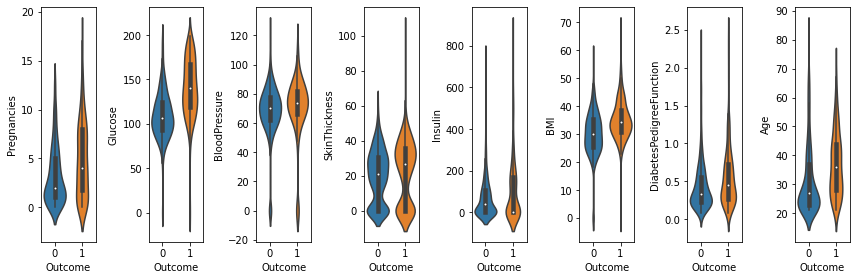

In [4]:
# Create 8 subplots, 1 for each feature
fig, axs = plt.subplots(1, 8, figsize=(12, 4))
# Plot distribution of each feature as a violin plot broken down by class label
for i, ax in enumerate(axs):
    sns.violinplot(ax=ax, data=df, x='Outcome', y=features[i])
fig.tight_layout()

There are differences between the distributions of the two classes for each feature, suggesting all features will be useful in predicting the presence of diabetes. The distinction between each class's distribution is more marked for some features than others, specifically pregnancies, glucose and age.

It is also apparent that a number of features have a significant proportion of records with zero values, particularly skin thickness and insulin. Pregnancies, glucose, blood pressure, skin thickness, insulin and BMI all contain at least one zero value. This is valid for number of pregnancies but thought to be invalid otherwise. As a result a data cleaning step will be performed to account for these values.

#### Cleaning
For feature values of zero in glucose, blood pressure, skin thickness, insulin and BMI, the value will be replaced by the mean of that feature of the subset of records belonging to the same class and excluding zero values.

In [5]:
# Helper function to work with data cleaning lambda
# For passed feature, updates 0 values to mean of feature for objects of same class
# Takes:
# - row: row of dataframe
# - feature: df column name
# - df: dataframe
def dataCleaningHelper(row, feature, df):
    # Check if feature value at row = 0 and class label of row = 0
    if row[feature] == 0 and row['Outcome'] == 0:
        # Update feature value to mean of feature for class label 0
        return df[(df['Outcome'] == 0) & (df[feature] != 0)][feature].mean()
    # Check if feature value at row = 0 and class label of row = 1
    elif row[feature] == 0 and row['Outcome'] == 1:
        # Update feature value to mean of feature for class label 1
        return df[(df['Outcome'] == 1) & (df[feature] != 0)][feature].mean()
    # Otherwise no update
    else:
        return row[feature]     

In [6]:
# Iterate over selected column headers
for feature in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    # Replace feature values of 0 with mean feature value of objects in same class
    df[feature] = df.apply(lambda row: dataCleaningHelper(row, feature, df), axis=1)

### Models and Analysis
The dataset is now ready to be used for development of our machine learning methods. The same procedure will be repeated for each method to enable our evaluation.
#### Setup
Hyperparameter tuning will done using grid search cross validation over a defined hyperparameter search space. Several evaluation metrics will be computed from the final test results for each method.

In [7]:
# Function to optimise algorithm hyperparameters
# Performs grid search with cross validation to evaluate hyperparameter combinations
# Takes:
# - algorithm: machine learning model object
# - searchSpace: dictionary containing hyperparameter names (keys) and list of values to search through (values)
# - X_train: training data feature values
# - y_train: training data class labels
def hyperparameterTuner(algorithm, searchSpace, X_train, y_train):
    # Initialise cross validator
    # Repeated to account for variance across samples
    # Stratified to ensure constant proportion of each classes in each fold
    crossValidator = RepeatedStratifiedKFold(n_splits=3, random_state=1, n_repeats=1) # update this before final
    # Initialise search
    # Grid search to perform exhaustive search of all hyperparameter combinations in searchSpace
    hyperparameterSearch = GridSearchCV(algorithm, searchSpace, scoring='accuracy', n_jobs=-1, cv=crossValidator)
    # Fit search with training data
    # Performs search over searchSpace
    hyperparameterSearch.fit(X_train, y_train)
    return hyperparameterSearch

In [8]:
# Helper function to compute and store evaluation metrics
# Takes:
# - confusion matrix: 2x2 array
# - name of algorithm used: str
def getEvaluationMetrics(confusionMatrix, algorithmName):
    # Extract counts of each result category from confusion matrix
    [tp, fp], [fn, tn] = confusionMatrix
    # Compute evaluation metrics
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fScore = (2*precision*recall)/(precision+recall)
    # Return metrics as dictionary
    return {'Algorithm':algorithmName, 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F-Score':fScore}

In [9]:
# Initialise empty dataframe to store model evaluation metrics
evaluationDf = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F-Score'])

#### K-Nearest Neighbours Classifier
##### Data preparation

In [10]:
# Split data into 80% train and 20% test sets
# Data stratified by class due to imbalance in classes (65% negative - 35% positive)
# Data shuffled to reduce any bias in the order of the dataset
# Define random state to ensure the same train test split can be used for each method
X_train, X_test, y_train, y_test = train_test_split(df[features],
                                                    df[target],
                                                    test_size=0.20,
                                                    stratify=df[target],
                                                    shuffle=True,
                                                    random_state=123,
                                                    )

# KNN method detrimentally impacted by differences between the units of features
# Normalise to account for this - updated features in range [0, 1]
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### Baseline model using default hyperparameters

In [11]:
# Create KNN classifier using default hyperparameters
knnBaselineModel = KNeighborsClassifier()
# Train model
knnBaselineModel.fit(X_train, y_train)
# Test model
knnBaselinePredictions = knnBaselineModel.predict(X_test)
print(f'KNN test accuracy: {100*((knnBaselinePredictions==y_test).sum()/y_test.shape[0]):.2f}%')

KNN test accuracy: 81.17%


##### Hyperparameter search space

In [12]:
# Define KNN hyperparameter search space
# Default values for parameters are shown in comments
searchSpace = {
#     'algorithm': 'auto',
#     'leaf_size': 30,
#     'metric': 'minkowski',
#     'metric_params': None,
#     'n_jobs': None,
    'n_neighbors': list(range(3,25,2)), # 'n_neighbors': 5,
    'p': [1, 2, 3], # 'p': 2,
    'weights': ['uniform', 'distance'] # 'weights': 'uniform'}
}

# Store dictionary of default hyperparameters used in search for plotting later
defaultParameters = {
    'n_neighbors': 5,
    'p': 2,
    'weights': 'uniform'
}

##### Perform search

In [13]:
# Create KNN classifier for hyperparameter search
knnSearchModel = KNeighborsClassifier()
# Perform search based on search space
search = hyperparameterTuner(knnSearchModel, searchSpace, X_train, y_train)
# Store best parameters found
optimumParameters = search.best_params_
# Store all results in new dataframe
results = pd.DataFrame(search.cv_results_)

##### Plot search results

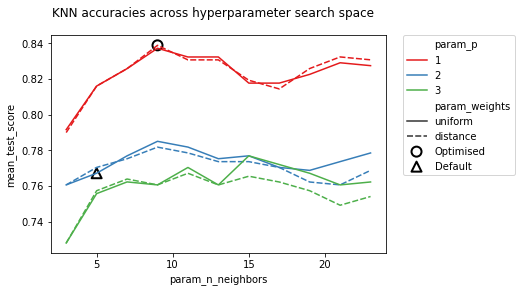

In [14]:
# Create figure for results
fig, ax = plt.subplots()
# Lineplot to display trend for each hyperparameter investigated
sns.lineplot(
    data=results,
    y='mean_test_score',
    x='param_n_neighbors',
    hue='param_p',
    style='param_weights',
    palette="Set1",
    ax=ax,
)

# Add point to highlight best accuracy achieved
ax.scatter(optimumParameters['n_neighbors'], results[results['params'] == optimumParameters]['mean_test_score'],
           facecolors='none',
           edgecolors='k',
           linewidth=2,
           s=100,
           label='Optimised',
           marker='o'
          )

# Add point to show accuracy achieved using default hyperparameters
ax.scatter(defaultParameters['n_neighbors'], results[results['params'] == defaultParameters]['mean_test_score'],
           facecolors='none',
           edgecolors='k',
           linewidth=2,
           s=100,
           label='Default',
           marker='^'
          )

# Move legend outside figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Fix x axis markers to whole numbers
ax.xaxis.get_major_locator().set_params(integer=True) 
# Add title
fig.suptitle('KNN accuracies across hyperparameter search space', fontsize=12)

#fig.savefig('kNN_hyperparameterSearchResults', bbox_inches='tight')
plt.show()

##### Test best hyperparameters

In [15]:
# Create KNN classifier using best parameters
knnBestModel = KNeighborsClassifier(
    n_neighbors=optimumParameters['n_neighbors'],
    p=optimumParameters['p'],
    weights=optimumParameters['weights']
)
# Train model
knnBestModel.fit(X_train, y_train)
# Test model
knnBestPredictions = knnBestModel.predict(X_test)
print(f'KNN test accuracy: {100*((knnBestPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

KNN test accuracy: 88.96%


##### Evaluation metrics

In [50]:
# Create confusion matrix for KNN optimised hyperparameter test results
confusionMatrixKNN = confusion_matrix(y_test, knnBestPredictions)
# Store evaluation metrics in dataframe
evaluationDf = evaluationDf.append(getEvaluationMetrics(confusionMatrixKNN, 'k-Nearest Neightbours'), ignore_index=True)

#### Random Forest
##### Data preparation

In [17]:
# Repeat data splitting process
# Use same random state to ensure the same train test split
X_train, X_test, y_train, y_test = train_test_split(df[features],
                                                    df[target],
                                                    test_size=0.20,
                                                    stratify=df[target],
                                                    shuffle=True,
                                                    random_state=123,
                                                    )

##### Baseline model using default hyperparameters

In [18]:
# Create KNN classifier using default hyperparameters
rfBaselineModel = RandomForestClassifier()
# Train model
rfBaselineModel.fit(X_train, y_train)
# Test model
rfBaselinePredictions = rfBaselineModel.predict(X_test)
print(f'Random Forest test accuracy: {100*((rfBaselinePredictions==y_test).sum()/y_test.shape[0]):.2f}%')

Random Forest test accuracy: 86.36%


##### Hyperparameter search space

In [19]:
# Define Random Forest hyperparameter search space
# Default values for parameters are shown in comments
searchSpace = {
#     'bootstrap': True,
#     'ccp_alpha': 0.0,
#     'class_weight': None,
    'criterion': ['gini', 'entropy'], # 'criterion': 'gini',
#     'max_depth': None,
    'max_features': [2, 3, 4, 5], # 'max_features': 'auto' (= square root of number of features)
#     'max_leaf_nodes': None,
#     'max_samples': None,
#     'min_impurity_decrease': 0.0,
#     'min_samples_leaf': 1,
#     'min_samples_split': 2,
#     'min_weight_fraction_leaf': 0.0,
    'n_estimators': [10, 100, 1000], # 'n_estimators': 100,
#     'n_jobs': None,
#     'oob_score': False,
#     'random_state': None,
#     'verbose': 0,
#     'warm_start': False
    }

# Store dictionary of default hyperparameters used in search for plotting later
defaultParameters = {
    'criterion': 'gini',
    'max_features': 3, # sqrt(8) ~ 3
    'n_estimators': 100,
}

##### Perform search

In [20]:
# Create KNN classifier for hyperparameter search
rfSearchModel = RandomForestClassifier()
# Perform search based on search space
search = hyperparameterTuner(rfSearchModel, searchSpace, X_train, y_train)
# Store best parameters found
optimumParameters = search.best_params_
# Store all results in new dataframe
results = pd.DataFrame(search.cv_results_)

##### Plot search results

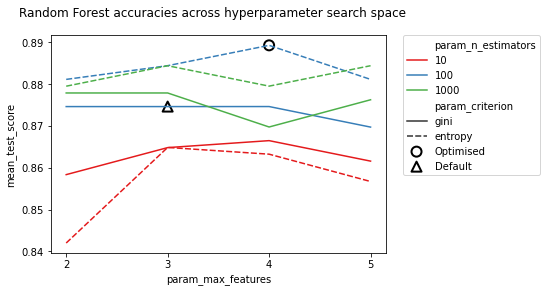

In [21]:
# Create figure for results
fig, ax = plt.subplots()
# Lineplot to display trend for each hyperparameter investigated
sns.lineplot(
    data=results,
    y='mean_test_score',
    x='param_max_features',
    hue='param_n_estimators',
    style='param_criterion',
    palette="Set1",
    ax=ax,
)

# Add point to highlight best accuracy achieved
ax.scatter(optimumParameters['max_features'], results[results['params'] == optimumParameters]['mean_test_score'],
           facecolors='none',
           edgecolors='k',
           linewidth=2,
           s=100,
           label='Optimised',
           marker='o'
          )

# Add point to show accuracy achieved using default hyperparameters
ax.scatter(defaultParameters['max_features'], results[results['params'] == defaultParameters]['mean_test_score'],
           facecolors='none',
           edgecolors='k',
           linewidth=2,
           s=100,
           label='Default',
           marker='^'
          )

# Move legend outside figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Fix x axis markers to whole numbers
ax.xaxis.get_major_locator().set_params(integer=True) 
# Add title
fig.suptitle('Random Forest accuracies across hyperparameter search space', fontsize=12)

#fig.savefig('RF_hyperparameterSearchResults', bbox_inches='tight')
plt.show()

##### Test best hyperparameters

In [22]:
# Create Random Forest classifier using best parameters
rfBestModel = RandomForestClassifier(
    criterion=optimumParameters['criterion'],
    max_features=optimumParameters['max_features'],
    n_estimators=optimumParameters['n_estimators'],
)
# Train model
rfBestModel.fit(X_train, y_train)
# Test model
rfBestPredictions = rfBestModel.predict(X_test)
print(f'Random Forest test accuracy: {100*((rfBestPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

Random Forest test accuracy: 88.96%


##### Evaluation metrics

In [24]:
# Create confusion matrix for KNN optimised hyperparameter test results
confusionMatrixRF = confusion_matrix(y_test, rfBestPredictions)
# Store evaluation metrics in dataframe
evaluationDf = evaluationDf.append(getEvaluationMetrics(confusionMatrixRF, 'Random Forest'), ignore_index=True)

#### Support Vector Machine Classifier
##### Data preparation

In [25]:
# Split data into 80% train and 20% test sets
# Data stratified by class due to imbalance in classes (65% negative - 35% positive)
# Data shuffled to reduce any bias in the order of the dataset
# Define random state to ensure the same train test split can be used for each method
X_train, X_test, y_train, y_test = train_test_split(df[features],
                                                    df[target],
                                                    test_size=0.20,
                                                    stratify=df[target],
                                                    shuffle=True,
                                                    random_state=123,
                                                    )

# Standardise features to negate the impact of different feature units
# Updated features have mean 0 and standard deviation 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### Baseline model using default hyperparameters

In [26]:
# Create support vector classifier using default hyperparameters
svcBaselineModel = SVC()
# Train model
svcBaselineModel.fit(X_train, y_train)
# Test model
svcBaselinePredictions = svcBaselineModel.predict(X_test)
print(f'Support Vector Classifier test accuracy: {100*((svcBaselinePredictions==y_test).sum()/y_test.shape[0]):.2f}%')

Support Vector Classifier test accuracy: 87.01%


##### Hyperparameter search space

In [39]:
# Define SVC hyperparameter search space
# Default values for parameters are shown in comments
searchSpace = {
    'C': np.logspace(-1, 2, num=4), # 'C': 1.0,
#     'break_ties': False,
#     'cache_size': 200,
#     'class_weight': None,
#     'coef0': 0.0,
#     'decision_function_shape': 'ovr',
    'degree': [2, 3, 4], # 'degree': 3, (only used for polynomial kernel)
#     'gamma': 'scale',
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # 'kernel': 'rbf',
#     'max_iter': -1,
#     'probability': False,
#     'random_state': None,
#     'shrinking': True,
#     'tol': 0.001,
#     'verbose': False
}

# Store dictionary of default hyperparameters used in search for plotting later
defaultParameters = {
    'C': 1.0,
    'degree': 3,
    'kernel': 'rbf',
}

##### Perform search

In [41]:
# Create SVC classifier for hyperparameter search
svcSearchModel = SVC()
# Perform search based on search space
search = hyperparameterTuner(svcSearchModel, searchSpace, X_train, y_train)
# Store best parameters found
optimumParameters = search.best_params_
# Store all results in new dataframe
results = pd.DataFrame(search.cv_results_)

##### Plot search results

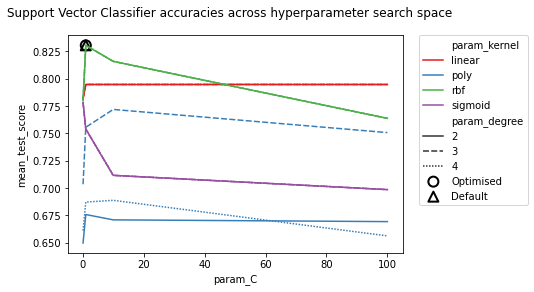

In [55]:
# Create figure for results
fig, ax = plt.subplots()
# Lineplot to display trend for each hyperparameter investigated
sns.lineplot(
    data=results,
    y='mean_test_score',
    x='param_C',
    hue='param_kernel',
    style='param_degree',
    palette="Set1",
    ax=ax,
)

# Add point to highlight best accuracy achieved
ax.scatter(optimumParameters['C'], results[results['params'] == optimumParameters]['mean_test_score'],
           facecolors='none',
           edgecolors='k',
           linewidth=2,
           s=100,
           label='Optimised',
           marker='o'
          )

# Add point to show accuracy achieved using default hyperparameters
ax.scatter(defaultParameters['C'], results[results['params'] == defaultParameters]['mean_test_score'],
           facecolors='none',
           edgecolors='k',
           linewidth=2,
           s=100,
           label='Default',
           marker='^'
          )

# Move legend outside figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Fix x axis markers to whole numbers
ax.xaxis.get_major_locator().set_params(integer=True) 
# Add title
fig.suptitle('Support Vector Classifier accuracies across hyperparameter search space', fontsize=12)

#fig.savefig('SVC_hyperparameterSearchResults', bbox_inches='tight')
plt.show()

##### Test best hyperparameters

In [45]:
# Create SVC using best parameters
svcBestModel = SVC(
    C=optimumParameters['C'],
    kernel=optimumParameters['kernel'],
    degree=optimumParameters['degree'],
)
# Train model
svcBestModel.fit(X_train, y_train)
# Test model
svcBestPredictions = svcBestModel.predict(X_test)
print(f'Support Vector Classifier test accuracy: {100*((svcBestPredictions==y_test).sum()/y_test.shape[0]):.2f}%')

Support Vector Classifier test accuracy: 87.01%


##### Evaluation metrics

In [49]:
# Create confusion matrix for SVC optimised hyperparameter test results
confusionMatrixSVC = confusion_matrix(y_test, svcBestPredictions)
# Store evaluation metrics in dataframe
evaluationDf = evaluationDf.append(getEvaluationMetrics(confusionMatrixSVC, 'Support Vector Classifier'), ignore_index=True)

### Evaluation

In [51]:
print(confusionMatrixKNN)

print(confusionMatrixRF)

print(confusionMatrixSVC)

[[97  3]
 [14 40]]
[[92  8]
 [ 9 45]]
[[97  3]
 [17 37]]


In [52]:
evaluationDf.set_index('Algorithm')

,Accuracy,Precision,Recall,F-Score
Algorithm,,,,
KNN,0.88961,0.97,0.873874,0.919431
Random Forest,0.88961,0.92,0.910891,0.915423
KNN,0.87013,0.97,0.850877,0.906542
Support Vector Classifier,0.87013,0.97,0.850877,0.906542
k-Nearest Neightbours,0.88961,0.97,0.873874,0.919431
